In [162]:
bucket = 'arch-ml-bucket-us-east-1'
prefix = 'mall_customer'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
import os
import pandas as pd
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
role = get_execution_role()

# Data Preprocessing

In [38]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [39]:
df.shape

(200, 5)

In [40]:
features = ['Annual Income (k$)', 'Spending Score (1-100)']
train_df = df[features]

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
train_df = pd.DataFrame(data=train_df, columns=features)
train_df = train_df.astype('float32')

In [42]:
train_df.to_csv('train.csv', header=False, index=False)

In [123]:
# Write Column List

with open('feature_list.txt','w') as f:
    f.write(','.join(features))

In [159]:
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(obj=scaler, file=f)    

# Upload data to S3

In [43]:
def write_to_s3(filename):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket)\
            .Object(os.path.join(prefix, filename)).upload_fileobj(f)

In [44]:
write_to_s3('train.csv')

# Train

In [45]:
container = get_image_uri(boto3.Session().region_name, 'kmeans')

In [46]:
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:1'

In [53]:
sess = sagemaker.Session()
output_path = 's3://{}/{}'.format(bucket, prefix)

estimator = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.xlarge',
                                       output_path=output_path,
                                       sagemaker_session=sess,
                                       job_name ='kmeans-mall-v1')

estimator.set_hyperparameters(k=3, feature_dim=2)

In [54]:
s3_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train.csv')
training_input_config = sagemaker.session.s3_input(s3_data=s3_data, content_type="text/csv;label_size=0")

In [55]:
estimator.fit({'train':training_input_config})

INFO:sagemaker:Creating training-job with name: kmeans-mall-v1-2019-05-07-08-37-34-282


2019-05-07 08:37:34 Starting - Starting the training job...
2019-05-07 08:37:35 Starting - Launching requested ML instances......
2019-05-07 08:38:43 Starting - Preparing the instances for training......
2019-05-07 08:39:58 Downloading - Downloading input data
2019-05-07 08:39:58 Training - Downloading the training image...
2019-05-07 08:40:33 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[05/07/2019 08:40:29 INFO 140518448154432] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_fact


2019-05-07 08:40:40 Completed - Training job completed
Billable seconds: 64


# Deploy Model to Endpoint

In [82]:
sess = sagemaker.Session()
model = sagemaker.model.Model (
    model_data = 's3://{}/{}/{}/output/model.tar.gz'.format(bucket, prefix, job_name), 
    image = container,
    role = role,
    sagemaker_session = sess)

In [ ]:
# Specify endpoint instance type and count
model.deploy(initial_instance_count = 1, 
             instance_type = 'ml.t2.medium', 
             endpoint_name='kmeans-mall-v1')

INFO:sagemaker:Creating model with name: kmeans-2019-05-07-11-13-09-244
INFO:sagemaker:Creating endpoint with name kmeans-mall-v1


-------------------------------------------------------------------------------------------------------------------------

# Acquire Endpoint & Make Prediction

In [89]:
endpoint_name = 'kmeans-mall-v1'
predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = None

In [129]:
input_features = ''
with open('feature_list.txt','r') as f:
    input_features = f.read().split(',')

In [140]:
data_to_cluster = pd.read_csv('train.csv', names=input_features)

In [141]:
pred = predictor.predict(data_to_cluster.values)

In [137]:
import json

pred_parsed = pred.decode('utf-8')
pred_parsed = json.loads(pred_parsed)

In [138]:
pred_parsed['predictions']

[{'distance_to_cluster': 1.1978631019592285, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.6218571662902832, 'closest_cluster': 2.0},
 {'distance_to_cluster': 2.0352628231048584, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.484636902809143, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.1125653982162476, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.430220127105713, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.9960898160934448, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.9587763547897339, 'closest_cluster': 2.0},
 {'distance_to_cluster': 2.079965829849243, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.2691645622253418, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.7122550010681152, 'closest_cluster': 2.0},
 {'distance_to_cluster': 2.1106014251708984, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.65875244140625, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1.378390908241272, 'closest_cluster': 2.0},
 {'distance_to_cluster': 1

In [139]:
result_clusters = list(map(lambda x: x['closest_cluster'], pred_parsed['predictions']))

## Get Params (specifically cluster centroids) Of The Model

In [ ]:
job_name='<your_SageMaker_KMeans_job_name_here>'
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

In [119]:
!pip install mxnet

    100% |████████████████████████████████| 28.4MB 1.8MB/s eta 0:00:01
    100% |████████████████████████████████| 13.8MB 6.5MB/s eta 0:00:01
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [120]:
import mxnet as mx

Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [121]:
Kmeans_model_params

[
 [[ 1.0249653   1.2370576 ]
  [ 1.0564572  -1.2010652 ]
  [-0.6283226   0.01383363]]
 <NDArray 3x2 @cpu(0)>]

In [151]:
centroids = Kmeans_model_params[0]
centroids = list(map(lambda x: x.asnumpy(), centroids))
centroids = list(map(lambda x: scaler.inverse_transform(x), centroids))

In [ ]:
data_to_cluster['cluster'] = result_clusters

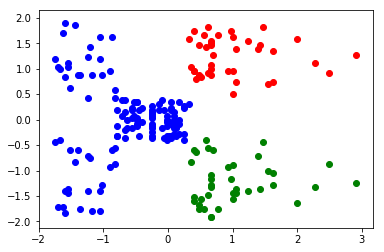

In [165]:
for i, c in enumerate(['red', 'green', 'blue']):
    filtered = data_to_cluster[data_to_cluster['cluster'] == i]
    plt.scatter(x=filtered['Annual Income (k$)'],
               y=filtered['Spending Score (1-100)'],
               c=c)